In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.ascii
import astropy.units as u
%matplotlib inline

## Here we will be installing the necessary package in order to utilize the pylightcurve functions

In [2]:
pip install pylightcurve

Note: you may need to restart the kernel to use updated packages.


## Next step is to read the observational data in from the exoplanet GJ 436 b gathered in Deming et al. 2007 utilizing the irac4 filter.

In [3]:
tr_data = astropy.io.ascii.read("UID_0057087_PLC_019.tbl", delimiter = '|')

## To simplify future calculations, the pylightcurve package will be imported, as well as defining an array for the time of measurements for the transit

In [4]:
import pylightcurve as plc

time_array = tr_data["HJD"].data

    Done!
Checking exotethys database...
Checking ephemerides database...
Checking photometry database...
Checking catalogues database...
    Done!
    Done!


## In order to properly generate a model for our transit we must generate values using the EXOFAST program offered on NASA's exoplanet archive. The inputs will be using the planetary and stellar data supplied by Maciejewski et al. 2014, and stellar temperature and metallicity supplied by Rosenthal et al. 2021. EXOFAST will provide an the limb darkening coeffeficients, eccentricity, planet radius over stellar radius, period, semi-major axis to stellar radius ratio, the inclination, periastron, and the mid time for our transit.

In [5]:
#linear and quadratic limb darkening coefficients
limb_darkening_coefficients = [-0.008618, 0.142604]

#ratio of planet to star radius
rp_over_rs = 0.084091

#planets orbital period
period = 2.643883

#Semi major axis ratio to radius of star
sma_over_rs = 13.852621

#eccentricity of the planet
eccentricity = 0.144864

#Inclination angle
inclination = 86.531278

#periastron measured in degrees
periastron = -15.215185

#midpoint of the transit time in our model
mid_time = 2454510.799853


## With this data we can then generate a model using the pylightcurve transit() function

In [6]:
flux_array = plc.transit(limb_darkening_coefficients , rp_over_rs, period, sma_over_rs, 
                                        eccentricity, inclination, periastron, mid_time, time_array, 'quad')

## To visualize our model, we plot it as well as the flux vs time below

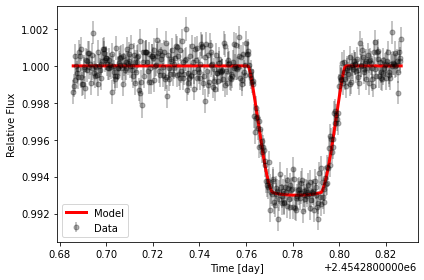

In [7]:
plt.errorbar(tr_data["HJD"], tr_data["Relative_Flux"],tr_data["Relative_Flux_Uncertainty"], ms=5, \
             marker="o", ls="none", label="Data", color="black", alpha=0.3)

plt.plot(time_array, flux_array, 'r-', lw=3, label="Model")
plt.ylim(plt.ylim()[0], plt.ylim()[1])
plt.xlabel('Time [day]')
plt.ylabel('Relative Flux')
plt.legend()
plt.tight_layout()

## A noticable dip can be seen in this plot. This represents $\delta$ which is the transit depth. To calculate this we first need to find the uncertainty in the depth by finding the standard deviation in the points around the line which will then provide this uncertainty. The boundaries of this transit will be determined by inspection. 

In [8]:
#Divides the transit up
transit_upper = tr_data[tr_data["HJD"] >= (0.77 + 2.4542800000 * 10**6)]
transit_data = transit_upper[transit_upper["HJD"] <= .793 + 2.4542800000 * 10**6]

In [9]:
#Computes the mean of these values
mean_rel_flux = sum(transit_data["Relative_Flux"] / len(transit_data['Relative_Flux']))

#computes the standard deviation of these values
standard_dev = np.sqrt(sum((transit_data["Relative_Flux"] - mean_rel_flux)**2)/len(transit_data['Relative_Flux']))
print(standard_dev)

0.0005860184985085983


## From here we can use the equation 
## $\delta = (\frac{R_{p}}{R_{star}})^{2}$

## to calculate the radius with some degree of uncertainty. We will be using the most recent measurement of the stellar radius supplied by Rosenthal et al. 2021

In [13]:
#Calculates delta as the difference between the max and min in the modeled fit
delta = flux_array.max()-flux_array.min()

R_star = 0.41684304009899997 * u.Rsun

R_star_uncertainty = 0.00756258617250750 *u.Rsun

#Calculates the radius of the planet
R_planet = R_star * np.sqrt(delta)

print(delta)

0.007003785014282893


## These measurements do have some form of error so before reporting definitively on the radius of GJ 436b, we must also calculate the uncertainty by propagating them through our calculations

In [11]:
R_planet_uncertainty = R_planet * np.sqrt((standard_dev/(2*delta))**2 + (R_star_uncertainty/R_star)**2)
print(R_planet.decompose().to(u.Rjupiter),'+-' , R_planet_uncertainty.decompose().to(u.Rjupiter))

0.33947165260640005 jupiterRad +- 0.01548001544920587 jupiterRad


## This gives our radius of our planet as ~.339 $\pm$ .015 R$_{Jupiter}$. This is on the same order of magnitude of the value presented by NASA on their exoplanet archive with radius of R $ = .372 R_{Jupiter}$ (Value sourced from https://exoplanets.nasa.gov/exoplanet-catalog/6534/gj-436-b/). This value is just over two standard deviations away from our radius found, and was produced in Maciejewski et al. 2014. 

## To cross reference this measurement with our model we can also generate a radius value using the stellar radius found by Maciejewski et al. 2014 of $R_{star} = .445 \pm 0.018 R_{sun}$

In [12]:
R_starM = 0.455 * u.Rsun

R_starM_uncertainty = 0.018 *u.Rsun

#Calculates the radius of the planet
R_planetM = R_starM * np.sqrt(delta)

R_planetM_uncertainty = R_planetM * np.sqrt((standard_dev/(2*delta))**2 + (R_starM_uncertainty/R_starM)**2)
print(R_planetM.decompose().to(u.Rjupiter),'+-' , R_planetM_uncertainty.decompose().to(u.Rjupiter))

0.3705461938364809 jupiterRad +- 0.02133543759348376 jupiterRad


## Using the older stellar data it produces a value $R = 0.370 \pm 0.021 R_{Jupiter}$ nearly identical to that found Maciejewski et al. 2014. Looking at other reports of the radius of the star GJ 436 it has been declining across numerous papers since 2014. This could explain our discrepancy in the radius data and raises further questions if new surveys measuring transit data of GJ 436b will be impacted the same way and report smaller radii as we have found with the updated measurements of GJ 436.